# Environment Setup

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# cd /content/drive/MyDrive/COMP4471/comp4471_final_project

In [ ]:
# !git pull

In [ ]:
# !nvidia-smi

In [1]:
import os
from PIL import Image
import numpy as np

import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from keras import layers
from dataset_sequence import DatasetSequence
from dataset_sequence_imagenet import DatasetSequenceImagenet
from custom_mse_loss import CustomMSELoss
from custom_mae_loss import CustomMAELoss
from custom_mae_loss_v2 import CustomMAELossV2
from custom_mae_loss_v3 import CustomMAELossV3
from unet import UNet

# Load the TensorBoard notebook extension
%load_ext tensorboard
import datetime

# Required to save models in HDF5 format
# !pip install pyyaml h5py

print(tf.__version__)

2.10.0


In [ ]:
# Clear any logs from previous runs
# !rd /s /q '.\logs'

In [2]:
# os.environ["CUDA_VISIBLE_DEVICES"]="0"
# gpu = tf.config.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(gpu[0], True)

# Build Model

In [5]:
model = UNet()
# Build model
model.build(input_shape=(None, 256, 256, 1))
model.build_graph().summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 encoder_block (EncoderBlock)   ((None, 128, 128, 6  37568       ['input_1[0][0]']                
                                4),                                                               
                                 (None, 256, 256, 6                                               
                                4))                                                               
                                                                                              

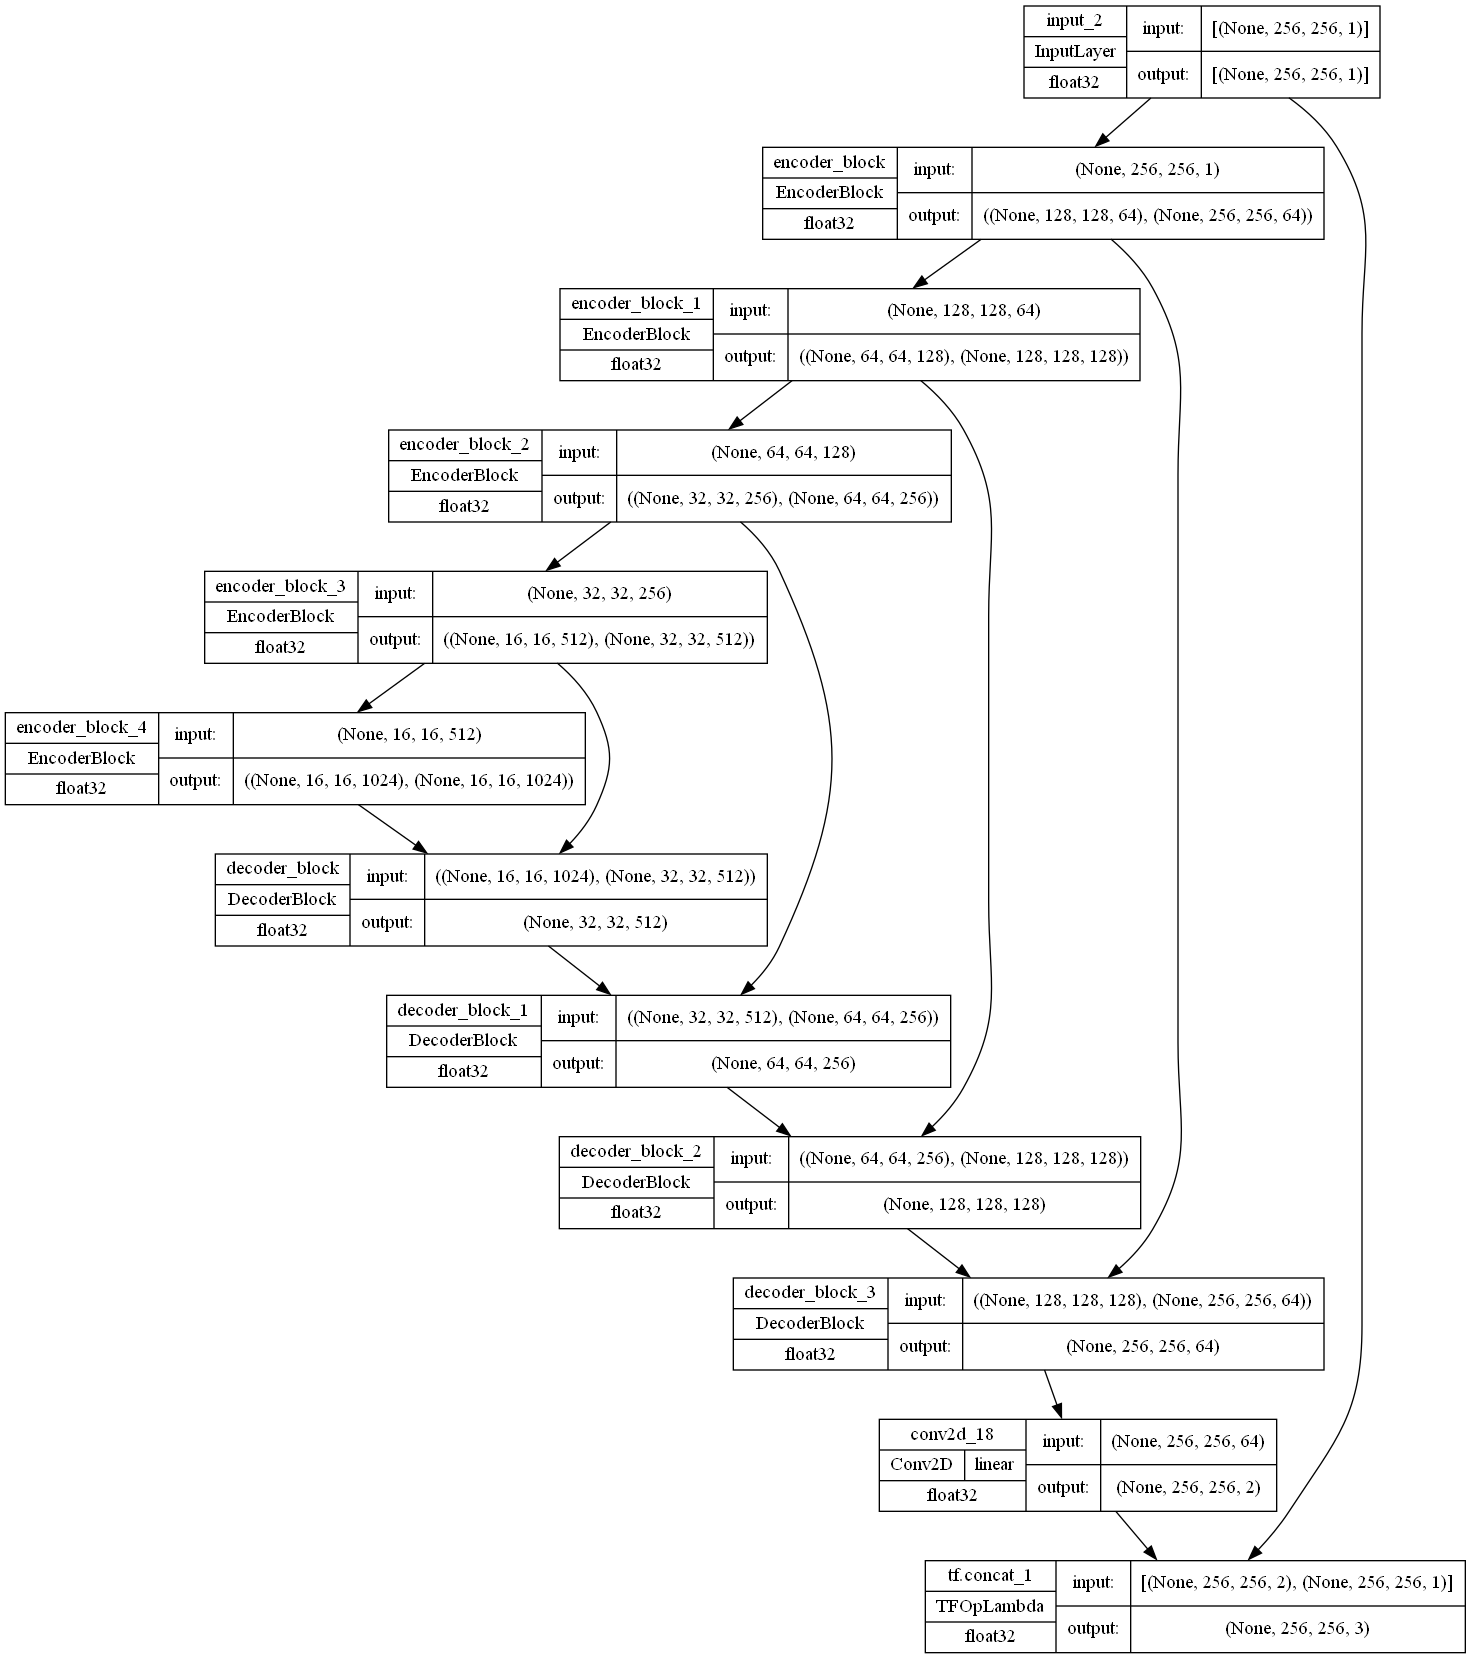

In [3]:
tf.keras.utils.plot_model(
    model.build_graph(),    # We call the build_graph() method
    to_file='model.png',
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=True,
    dpi=96,
    layer_range=None,
    show_layer_activations=True
)

# Learning

In [2]:
#@title Parameters { run: "auto", display-mode: "form" }

#@markdown ### Learning Parameters
batch_size = 16 #@param {type:"integer"}
epochs = 2 #@param {type:"integer"}
learning_rate = 1e-4 #@param {type:"number"}

#@markdown ---
#@markdown ### Loading Model
load_model = False #@param {type:"boolean"}
load_latest = True #@param {type:"boolean"}
load_path = "imagenet_mae_alpha_v3_ep5-6/unet-{epoch:04d}.ckpt" #@param {type:"string"}

#@markdown ---
#@markdown ### Saving Model
save_model = True #@param {type:"boolean"}
checkpoint_path = "imagenet_mae_alpha_v3_ep5-6/unet-{epoch:04d}.ckpt" #@param {type:"string"}
checkpoint_dir = os.path.dirname(checkpoint_path)
save_every_x_epochs = 1 #@param {type:"integer"}

callbacks = []

## Load Data

In [3]:
# dataset_path = './dataset_split'
# dataset_path = './dataset_mini'
dataset_path = './imagenet_2010'
# train_ds = DatasetSequence(dataset_path, batch_size=32, split='train', image_size=(256, 256))
# test_ds = DatasetSequence(dataset_path, batch_size=32, split='test', image_size=(256, 256))
# val_ds = DatasetSequence(dataset_path, batch_size=32, split='val', image_size=(256, 256))

train_ds = DatasetSequenceImagenet(dataset_path, batch_size=batch_size, split='train', image_size=(256, 256))
test_ds = DatasetSequenceImagenet(dataset_path, batch_size=batch_size, split='test', image_size=(256, 256))
val_ds = DatasetSequenceImagenet(dataset_path, batch_size=batch_size, split='val', image_size=(256, 256))

n_batches = len(train_ds)

In [5]:
print(len(train_ds))
print(len(test_ds))
print(len(val_ds))

78837
9375
3125


## Start learning

In [5]:
# Load saved weights
if load_model:
  if load_latest:
    load_path = tf.train.latest_checkpoint(checkpoint_dir)
  model.load_weights(load_path)

In [6]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
# optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
loss = CustomMAELossV3(alpha=1.0)
# loss = 'mse'
# loss_metric = tf.keras.metrics.Mean()
loss_metric = ['mae']

model.compile(optimizer=optimizer, loss=loss, metrics=loss_metric)

In [7]:
if save_model:
  #Save the model

  # Create a callback that saves the model's weights
  save_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                  save_weights_only=True,
                                                  verbose=1,
                                                  save_freq=save_every_x_epochs*n_batches) #Every x epoch
  callbacks.append(save_callback)

In [8]:
# Tensor Board callback
log_dir = "logs_imagenet_mae_v3/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
callbacks.append(tensorboard_callback)

In [73]:
results = model.fit(
          train_ds,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=val_ds,
          callbacks=callbacks)

Epoch 1/2
 1646/78837 [..............................] - ETA: 12:11:38 - loss: 0.1161 - mae: 0.1161

C:\Users\super\Desktop\python_projects\assignments_comp_vision\comp4471_final_project\venv_final_project_cv\lib\site-packages\PIL\TiffImagePlugin.py:850: UserWarning: Truncated File Read
  warnings.warn(str(msg))


15722/78837 [====>.........................] - ETA: 10:23:36 - loss: 0.1164 - mae: 0.1164

C:\Users\super\Desktop\python_projects\assignments_comp_vision\comp4471_final_project\venv_final_project_cv\lib\site-packages\PIL\TiffImagePlugin.py:850: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


67527/78837 [========================>.....] - ETA: 1:53:16 - loss: 0.1162 - mae: 0.1162

C:\Users\super\Desktop\python_projects\assignments_comp_vision\comp4471_final_project\venv_final_project_cv\lib\site-packages\PIL\TiffImagePlugin.py:850: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


78836/78837 [============================>.] - ETA: 0s - loss: 0.1162 - mae: 0.1162
Epoch 1: saving model to imagenet_mae_alpha_v3_ep5-6\unet-0001.ckpt
78837/78837 [==============================] - 47550s 603ms/step - loss: 0.1162 - mae: 0.1162 - val_loss: 0.1155 - val_mae: 0.1155
Epoch 2/2
78836/78837 [============================>.] - ETA: 0s - loss: 0.1145 - mae: 0.1145
Epoch 2: saving model to imagenet_mae_alpha_v3_ep5-6\unet-0002.ckpt
78837/78837 [==============================] - 45843s 581ms/step - loss: 0.1145 - mae: 0.1145 - val_loss: 0.1150 - val_mae: 0.1150


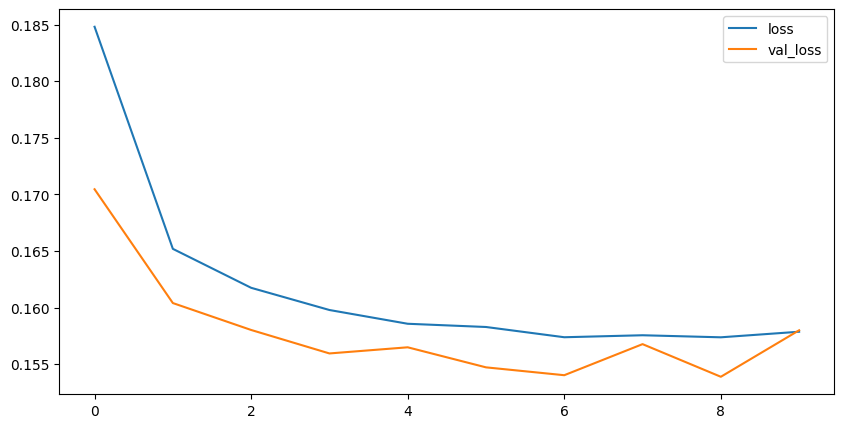

In [11]:
# NOTE: this graphs were produced during an experimenting phase,
# they are not representative of the final training results

# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(results.history['loss'], label='loss')
plt.plot(results.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

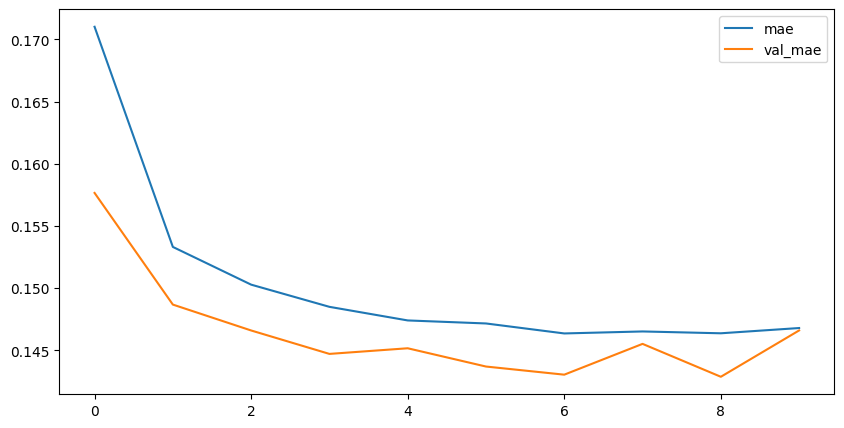

In [12]:
# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(results.history['mae'], label='mae')
plt.plot(results.history['val_mae'], label='val_mae')
plt.legend()
plt.show()

In [176]:
# Load the first checkpoint in folder './imagenet_mae_alpha_v3'
model.load_weights('imagenet_mae_alpha_v3/unet-0001.ckpt')

In [277]:
# Load the first checkpoint in folder './imagenet_mae_alpha_v3_ep3-4'
model.load_weights('imagenet_mae_alpha_v3_ep3-4/unet-0002.ckpt')

In [294]:
# Load last checkpoint in folder './imagenet_mae_alpha_v3_ep5-6'
model.load_weights('imagenet_mae_alpha_v3_ep5-6/unet-0002.ckpt')

1/1 [==============================] - 0s 26ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


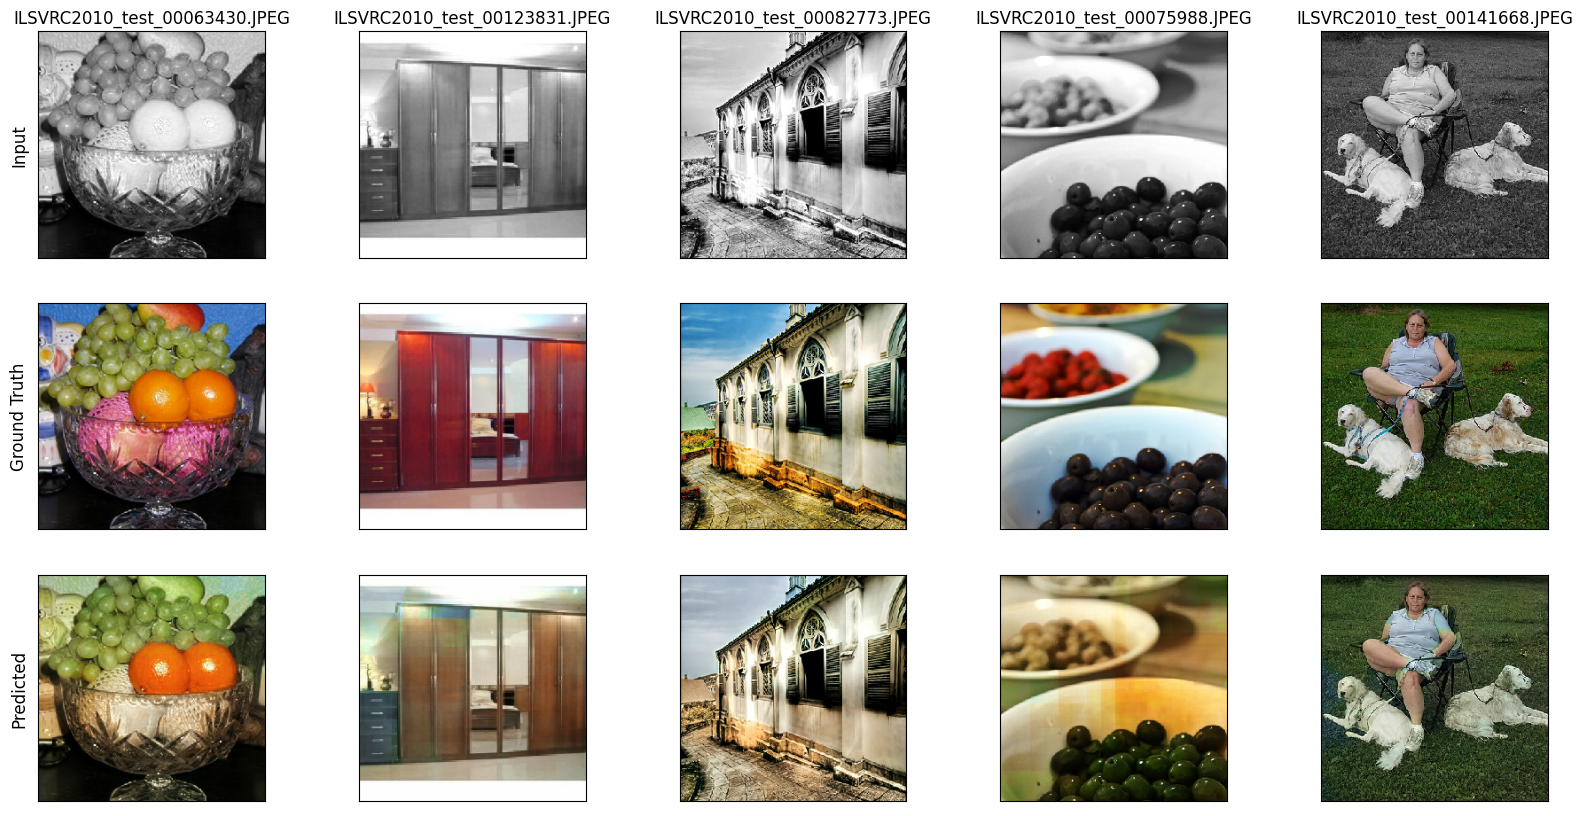

In [250]:
# Predict on a batch of 32 test images and plot the results

target_ds = 'test'
batch_num = 530

if target_ds == 'test':
  ds = test_ds
elif target_ds == 'val':
  ds = val_ds
else:
  ds = train_ds

batch = ds[batch_num]

# batch[0][i] is a (256, 256, 1) V channel image (input)
# batch[1][i] is a (256, 256, 3) HSV image

# Predict
pred = model.predict(batch[0])

# Plot 5 images in (3, 5) grid
# In the first row, plot the input image
# In the second row, plot the ground truth
# In the third row, plot the predicted image
# Remember to convert the predicted and ground truth images from HSV to RGB

fig, axes = plt.subplots(3, 5, figsize=(20, 10))
for i in range(5):
    axes[0, i].imshow(batch[0][i, ..., 0], cmap='gray')
    axes[1, i].imshow(tf.image.hsv_to_rgb(batch[1][i]))
    axes[2, i].imshow(tf.image.hsv_to_rgb(pred[i]))

# Add titles to the rows on the left
axes[0, 0].set_ylabel('Input', size='large')
axes[1, 0].set_ylabel('Ground Truth', size='large')
axes[2, 0].set_ylabel('Predicted', size='large')

# Add the name of the image as title to the columns
# The name of the image is the "test", "val" or "train" attribute of the dataset
for i in range(5):
    if target_ds == 'test':
        # Only keep the letters after the last slash of the path
        axes[0, i].set_title(ds.test[batch_num*batch_size + i].split('\\')[-1])
    elif target_ds == 'val':
        axes[0, i].set_title(ds.val[batch_num*batch_size + i].split('\\')[-1])
    else:
        axes[0, i].set_title(ds.train[batch_num*batch_size + i].split('\\')[-1])

for ax in axes.flatten():
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()


1/1 [==============================] - 0s 27ms/step


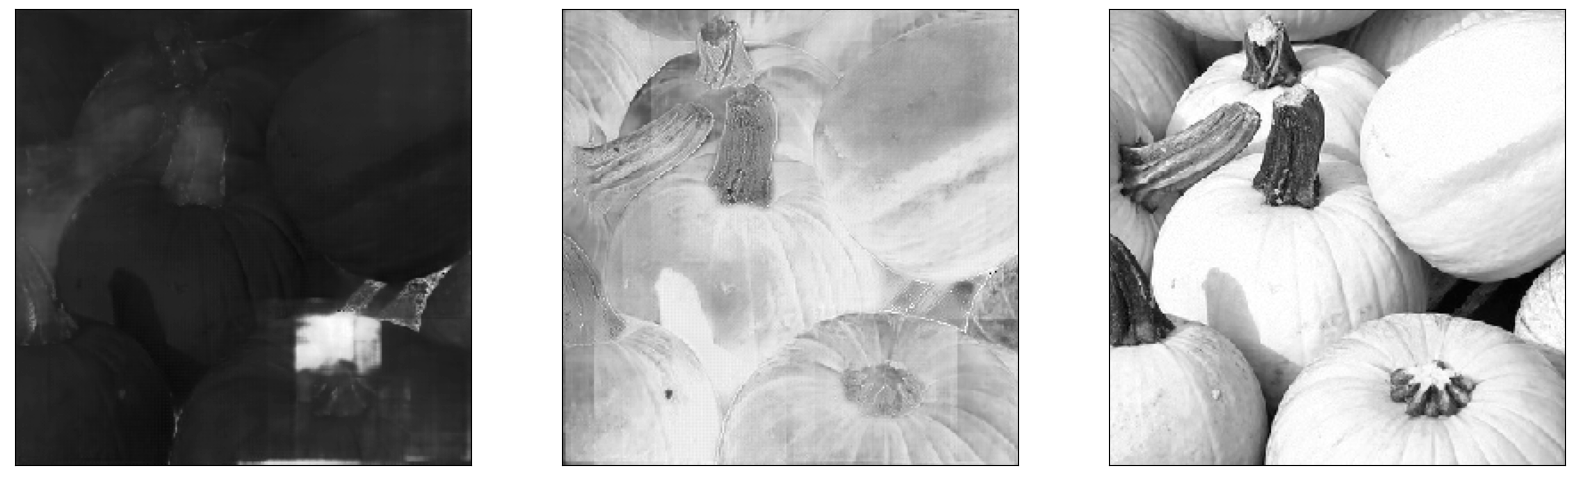

In [65]:
batch = test_ds[1]
image = batch[0][2]
# Plot the 3 HSV channels of the predicted image
pred = model.predict(image[tf.newaxis, ...])
fig, axes = plt.subplots(1, 3, figsize=(20, 10))
axes[0].imshow(pred[0, ..., 0], cmap='gray')
axes[1].imshow(pred[0, ..., 1], cmap='gray')
axes[2].imshow(pred[0, ..., 2], cmap='gray')
# Name the axes
axes[0].set_title('Hue')
axes[1].set_title('Saturation')
axes[2].set_title('Value')
for ax in axes.flatten():
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

# Show results

In [12]:
%tensorboard --logdir logs_depth_2/fit

Launching TensorBoard...

# Try to Improve model

In [ ]:
# We will use the U-Net model as the backbone of our model
# The backbone will be frozen and we will add a network to reduce the nise and artifacts in the predicted image (the output of the backbone).
# The backbone is already trained, but produces colorized HSV images with noise and artifacts in the channels H and S.

# The head will take the output of the backbone and produce a clean HSV image with the same dimensions as the input image.
# The head will be trained to minimize the loss between the predicted image and the ground truth image.

# We will use a kind of autoencoder to reduce the noise and artifacts in the predicted image.
# The autoencoder will take the output of the backbone and produce a clean HSV image with the same dimensions as the input image.

# The backbone will be frozen and the head will be trained to minimize the loss between the predicted image and the ground truth image.

In [5]:
# Define the new model
batch_size = 16

# The backbone is the U-Net model
base_model = UNet()
# Build model
base_model.build(input_shape=(None, 256, 256, 1))
# Load weights
base_model.load_weights('imagenet_mae_alpha_v3_ep5-6/unet-0002.ckpt')
# Freeze backbone
base_model.trainable = False

inputs = tf.keras.Input(shape=(256, 256, 1), batch_size=batch_size)
x = base_model(inputs)

# The head is a kind of autoencoder

# Encoder
x = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D(2, padding='same')(x)
x = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D(2, padding='same')(x)
x = tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D(2, padding='same')(x)
x = tf.keras.layers.Conv2D(8, 3, activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D(2, padding='same')(x)
x = tf.keras.layers.Conv2D(4, 3, activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D(2, padding='same')(x)

# Decoder
x = tf.keras.layers.Conv2D(4, 3, activation='relu', padding='same')(x)
x = tf.keras.layers.UpSampling2D(2)(x)
x = tf.keras.layers.Conv2D(8, 3, activation='relu', padding='same')(x)
x = tf.keras.layers.UpSampling2D(2)(x)
x = tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same')(x)
x = tf.keras.layers.UpSampling2D(2)(x)
x = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same')(x)
x = tf.keras.layers.UpSampling2D(2)(x)
x = tf.keras.layers.Conv2D(64, 2, activation='relu', padding='same')(x)
x = tf.keras.layers.UpSampling2D(2)(x)
# Concatenate input to network (V channel) to output of network (H and S channels)
x = tf.keras.layers.Concatenate()([x, inputs])

# Output
outputs = tf.keras.layers.Conv2D(3, 3, activation='sigmoid', padding='same')(x) # We use sigmoid activation because the output is in the range [0, 1]

# Eliminate third channel (V channel)
outputs = outputs[..., :2]

# Concatenate input to network (V channel) to output of network (H and S channels)
outputs = tf.keras.layers.Concatenate()([outputs, inputs])

model = tf.keras.Model(inputs=inputs, outputs=outputs, name='colorizer')
model.summary()


Model: "colorizer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(16, 256, 256, 1)]  0           []                               
                                                                                                  
 u_net_1 (UNet)                 (16, 256, 256, 3)    31030658    ['input_1[0][0]']                
                                                                                                  
 conv2d_38 (Conv2D)             (16, 256, 256, 64)   1792        ['u_net_1[0][0]']                
                                                                                                  
 max_pooling2d_8 (MaxPooling2D)  (16, 128, 128, 64)  0           ['conv2d_38[0][0]']              
                                                                                          

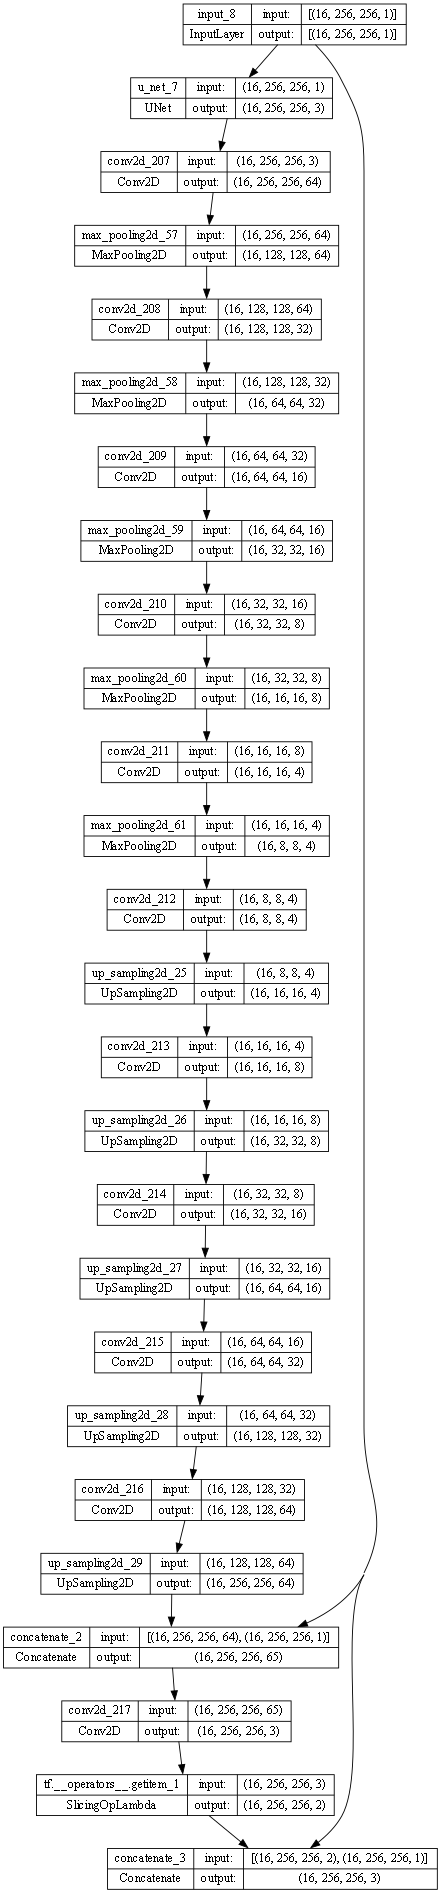

In [86]:
# Plot the model
tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

In [6]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.MeanAbsoluteError()])

In [26]:
# We want to save the weights of the model after each epoch
# We will use the ModelCheckpoint callback to do that

# Define the callbacks
# Save the weights of the model after each 5 epochs
checkpoint_path = 'colorizer_v2/colorizer_v2-{epoch:04d}.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 save_freq=100*len(train_ds))

In [27]:
# Tensor Board callback
log_dir = "colorizer_v2/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [28]:
# Train the model
results = model.fit(train_ds,
                    epochs=100,
                    validation_data=test_ds,
                    callbacks=[cp_callback, tensorboard_callback])

Epoch 1/100
1/1 [==============================] - 5s 5s/step - loss: 0.0435 - mean_absolute_error: 0.1382 - val_loss: 0.0323 - val_mean_absolute_error: 0.1142
Epoch 2/100
1/1 [==============================] - 6s 6s/step - loss: 0.0432 - mean_absolute_error: 0.1373 - val_loss: 0.0323 - val_mean_absolute_error: 0.1143
Epoch 3/100
1/1 [==============================] - 5s 5s/step - loss: 0.0429 - mean_absolute_error: 0.1365 - val_loss: 0.0325 - val_mean_absolute_error: 0.1146
Epoch 4/100
1/1 [==============================] - 6s 6s/step - loss: 0.0427 - mean_absolute_error: 0.1358 - val_loss: 0.0327 - val_mean_absolute_error: 0.1149
Epoch 5/100
1/1 [==============================] - 5s 5s/step - loss: 0.0427 - mean_absolute_error: 0.1353 - val_loss: 0.0329 - val_mean_absolute_error: 0.1153
Epoch 6/100
1/1 [==============================] - 5s 5s/step - loss: 0.0426 - mean_absolute_error: 0.1348 - val_loss: 0.0331 - val_mean_absolute_error: 0.1156
Epoch 7/100
1/1 [=======================

1/1 [==============================] - 0s 26ms/step


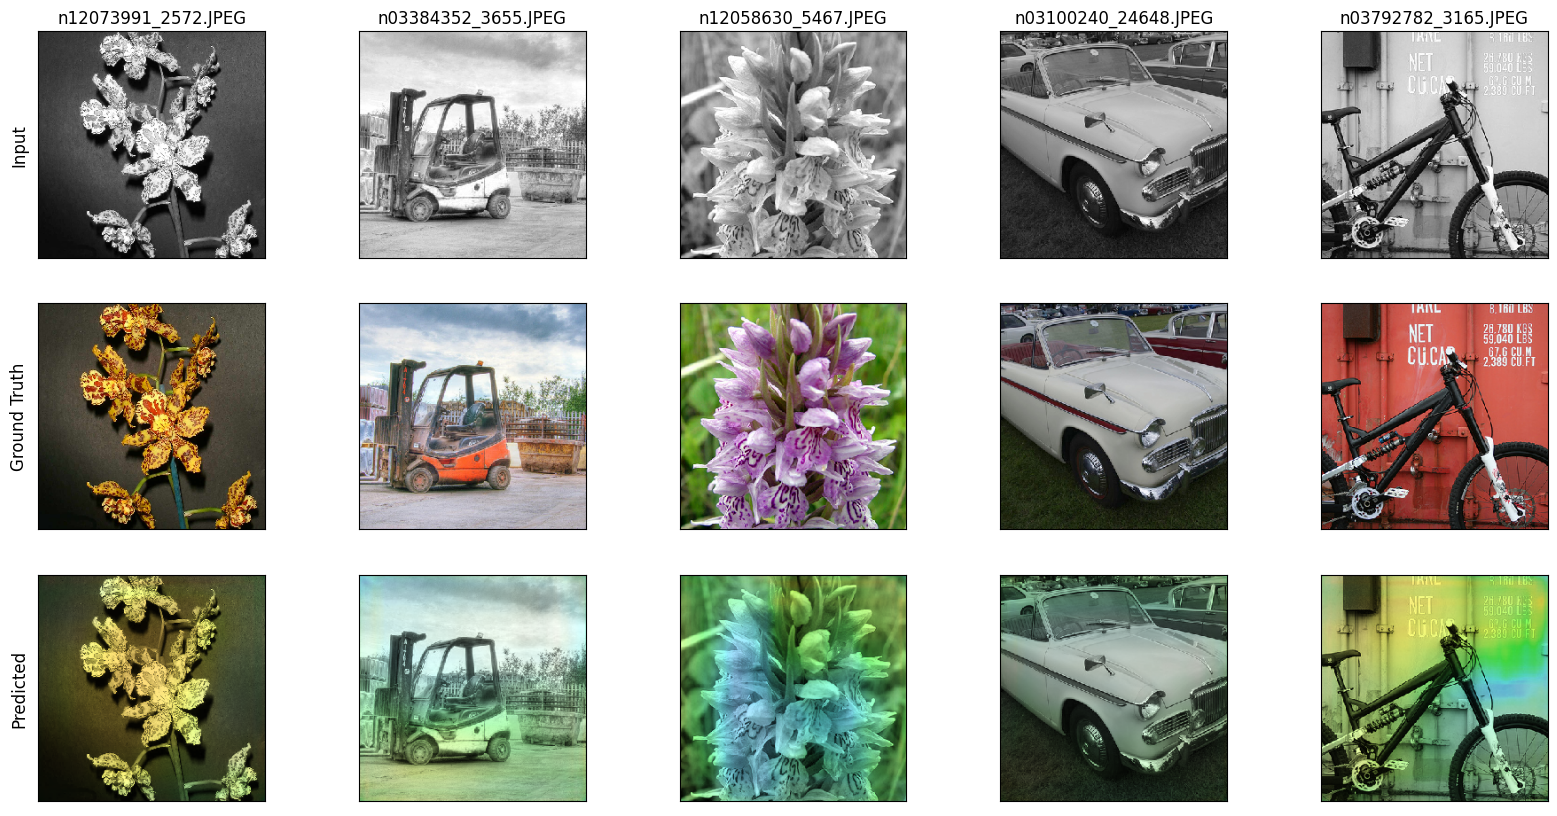

In [32]:
# Predict on a batch of 32 test images and plot the results

target_ds = 'train'
batch_num = 0

if target_ds == 'test':
  ds = test_ds
elif target_ds == 'val':
  ds = val_ds
else:
  ds = train_ds

batch = ds[batch_num]

# batch[0][i] is a (256, 256, 1) V channel image (input)
# batch[1][i] is a (256, 256, 3) HSV image

# Predict
pred = model.predict(batch[0])

# Plot 5 images in (3, 5) grid
# In the first row, plot the input image
# In the second row, plot the ground truth
# In the third row, plot the predicted image
# Remember to convert the predicted and ground truth images from HSV to RGB

fig, axes = plt.subplots(3, 5, figsize=(20, 10))
for i in range(5):
    axes[0, i].imshow(batch[0][i, ..., 0], cmap='gray')
    axes[1, i].imshow(tf.image.hsv_to_rgb(batch[1][i]))
    # Replace third channel of predicted image with input image
    axes[2, i].imshow(tf.image.hsv_to_rgb(tf.concat([pred[i, ..., :2], batch[0][i, ..., 0:1]], axis=-1)))

# Add titles to the rows on the left
axes[0, 0].set_ylabel('Input', size='large')
axes[1, 0].set_ylabel('Ground Truth', size='large')
axes[2, 0].set_ylabel('Predicted', size='large')

# Add the name of the image as title to the columns
# The name of the image is the "test", "val" or "train" attribute of the dataset
for i in range(5):
    if target_ds == 'test':
        # Only keep the letters after the last slash of the path
        axes[0, i].set_title(ds.test[batch_num*batch_size + i].split('\\')[-1])
    elif target_ds == 'val':
        axes[0, i].set_title(ds.val[batch_num*batch_size + i].split('\\')[-1])
    else:
        axes[0, i].set_title(ds.train[batch_num*batch_size + i].split('\\')[-1])

for ax in axes.flatten():
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()


# Save modif of files

In [ ]:
!git config --global credential.helper store
!git config --global credential.helper 'cache --timeout 7200'

In [ ]:
!git remote set-url origin git@github.com:Dario-CP/comp4471_final_project.git

In [ ]:
!git remote -v

In [ ]:
!git add ./U_net.ipynb
!git commit -m "auto modif U_net"
!git push git@github.com:Dario-CP/comp4471_final_project.git

# Show results

In [55]:
%tensorboard --logdir logs/fit

<IPython.core.display.Javascript object>

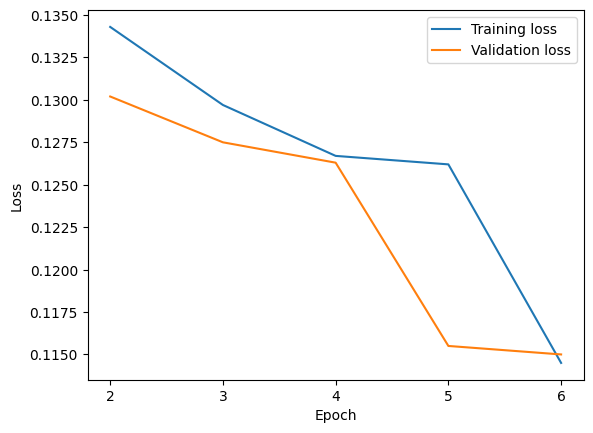

In [230]:
# Data manually recorded
train_loss_history = [0.1343, 0.1297, 0.1267, 0.1262, 0.1145]
val_loss_history = [0.1302, 0.1275, 0.1263, 0.1155, 0.1150]

# Plot the training and validation loss, starting from epoch 2 and only showing integer values on the x-axis
plt.plot(range(2, len(train_loss_history)+2), train_loss_history, label='Training loss')
plt.plot(range(2, len(val_loss_history)+2), val_loss_history, label='Validation loss')
plt.xticks(range(2, len(train_loss_history)+2))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Try the model on custom image

# Load the image
img = tf.io.read_file('...')
# img = tf.image.decode_jpeg(img, channels=3)

# Convert png to 3 channels
img = tf.image.decode_png(img, channels=3)

# Resize the image to (256, 256)
img = tf.image.resize(img, (256, 256))

# Convert the images to float32
img= tf.cast(img, tf.float32)

# Normalize the image
img = img/255.0

gt = img

# b_w = tf.image.rgb_to_grayscale(img)
# b_w = tf.image.grayscale_to_rgb(b_w)


# Convert the image to HSV
img = tf.image.rgb_to_hsv(img)
# b_W = tf.image.rgb_to_hsv(b_w)

# Extract the V channel
img = img[..., 2:3]

# Reshape the V channel to have the same number of dimensions as the input
img = tf.reshape(img, (256, 256, 1))

# Predict
pred = model.predict(img[tf.newaxis, ...])

# Convert the predicted image from HSV to RGB

pred = tf.image.hsv_to_rgb(pred[0])

# Plot the input image, ground truth and predicted image
fig, axes = plt.subplots(1, 3, figsize=(20, 10))
axes[0].imshow(img[..., 0], cmap='gray')
axes[1].imshow(gt)
axes[2].imshow(pred)
axes[0].set_title('Input', size='large')
axes[1].set_title('Ground Truth', size='large')
axes[2].set_title('Predicted', size='large')
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()
